In [1]:
# Dynamic Hand Gestures Classification
# pyright: reportGeneralTypeIssues=false
# pyright: reportWildcardImportFromLibrary=false
%reset -f
# ---------------------------------------------------------
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# ---
from fastai.vision.all import *
from exp00_model_zoo import *
from exp00_helper_functions import *
from IPython.display import clear_output

In [57]:
class Arguments:
    def __init__(self, ds_name, n_classes, idx_gpu=0):
        assert ds_name in ["CNR", "LMDHG", "FPHA", "DHG1428", "SHREC2017"]
        assert n_classes in [13, 14, 16, 28, 45]
        assert idx_gpu in [0, 1, 2, 3]

        # --- required arguments
        self.idx_gpu = idx_gpu
        self.n_classes = n_classes
        self.ds_name = ds_name

        # --- arguments with default options
        self.nd = "3d"
        self.bs = 16
        self.mvo_architecture = "resnet50"
        self.tnr_architecture = "resnet18"
        self.learn_directory = "../models/e2eET-Final-Checkpoints"
        self.ds_directory = f"../images_d/{datasetDirectories[f'{self.ds_name}{self.n_classes}']}"


        # --- arguments with dataset-specific values
        self.mv_orientations = datasetOptimalConfigs[f"{self.ds_name}{self.n_classes}"][0].split()
        self.init_img_sz = datasetOptimalConfigs[f"{self.ds_name}{self.n_classes}"][1]
        self.bm_accuracy = datasetOptimalConfigs[f"{self.ds_name}{self.n_classes}"][2]
        self.bm_checkpoint_pth = datasetOptimalConfigs[f"{self.ds_name}{self.n_classes}"][3]
        self.cm_title=f"{self.ds_name} {self.nd.upper()} {self.n_classes}G\nmVOs: [{(' | '.join(self.mv_orientations)).replace('-', '')}]\nClassification Accuracy: {self.bm_accuracy*100}%"


        # --- dummy arguments to fool `exp00_functions_classes`
        self.itr_scl_sizes = ["<OPT>"]
        self.verbose = False


In [59]:
# ---
args = Arguments(ds_name="DHG1428", n_classes=28, idx_gpu=0)
# ---

In [4]:
# [init.hypervariables.functions.classes]
defaults.device = torch.device("cuda", args.idx_gpu)
torch.cuda.set_device(args.idx_gpu)

deets = multiDetailsParser(
    e_desc=None, e_tag=None, e_secret=None, e_model_tag=None,
    learn_directory=args.learn_directory, ds_directory=args.ds_directory,
    e_repr_seed=None, e_stt_datetime=None, e_strftime=None, e_details=None,
)

from exp00_functions_classes import *


# [create.dls.model.learn]
# ---------------------------
dls = multiOrientationDataLoader(args.ds_directory, bs=args.bs, img_size=args.init_img_sz, e2eTunerMode=True, preview=False)

model = end2endTunerModel(
    archMultiVOs=BaseArchitectures[args.mvo_architecture],
    archTuner=BaseArchitectures[args.tnr_architecture],
    dls_vocab=dls.vocab,
    tuner_img_sz=args.init_img_sz,
)

attachMetrics(e2eTunerLossWrapper, args.mv_orientations, rename=True)
loss_func = e2eTunerLossWrapper(nOutputs=len(args.mv_orientations)+1)
metrics = returnMetrics(loss_func, args.mv_orientations, verbose=False)
learn = Learner(
    dls, model,
    metrics=metrics, loss_func=loss_func,
    opt_func=Adam, splitter=model.splitter,
    path=args.learn_directory, model_dir="."
)


In [5]:
# [tunerEvaluation.classificationInterpretation]
# ---------------------------
learn.load(args.bm_checkpoint_pth, with_opt=True)
preds, targs, decoded = learn.get_preds(dl=dls.valid, with_decoded=True)

tags = [_vo.title() for _vo in args.mv_orientations]
_learn_accuracies = [round((sum(i_d == targs) / len(targs)).item(), ndigits=4) for i_d in decoded]
_learn_accuracies = dict(zip([*tags, "Tuner"], _learn_accuracies))

learn_accuracy = _learn_accuracies["Tuner"]
assert learn_accuracy == args.bm_accuracy, "ValidationError: `e2eTunerLearnerEvaluation` returned unexpected learner classification accuracy!"

preds, decoded = preds[-1], decoded[-1]
dummy_inputs = dummy_losses = preds

clear_output(wait=False)
print(f"accuracies@e2eEnsembleTuner: {_learn_accuracies}")
print(f"bm_accuracy={learn_accuracy=}")

accuracies@e2eEnsembleTuner: {'Custom': 0.706, 'Top-Down': 0.6583, 'Front-Away': 0.7393, 'Tuner': 0.9238}
bm_accuracy=learn_accuracy=0.9238


In [75]:
@patch
def plot_confusion_matrix(self:ClassificationInterpretation, normalize=True, title="Confusion Matrix",
                            add_grid=False, cmap="Blues", norm_dec=2, **kwargs):
    "Plot the confusion matrix, with `title` and using `cmap`."
    # This function is mainly copied from the sklearn docs

    cm = self.confusion_matrix()
    if normalize: cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(**kwargs)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, size="large", fontweight="600")

    tick_marks = np.arange(len(self.vocab))
    plt.yticks(tick_marks, self.vocab, rotation=0)
    plt.xticks([])

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > 0.0:
            coeff = f"{cm[i, j]:.{norm_dec}f}" if normalize else f"{cm[i, j]}"
            plt.text(
                j, i, coeff,
                horizontalalignment="center", verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    ax = fig.gca()
    ax.set_ylim(len(self.vocab) - 0.5, -0.5)

    plt.tight_layout()
    plt.grid(add_grid)


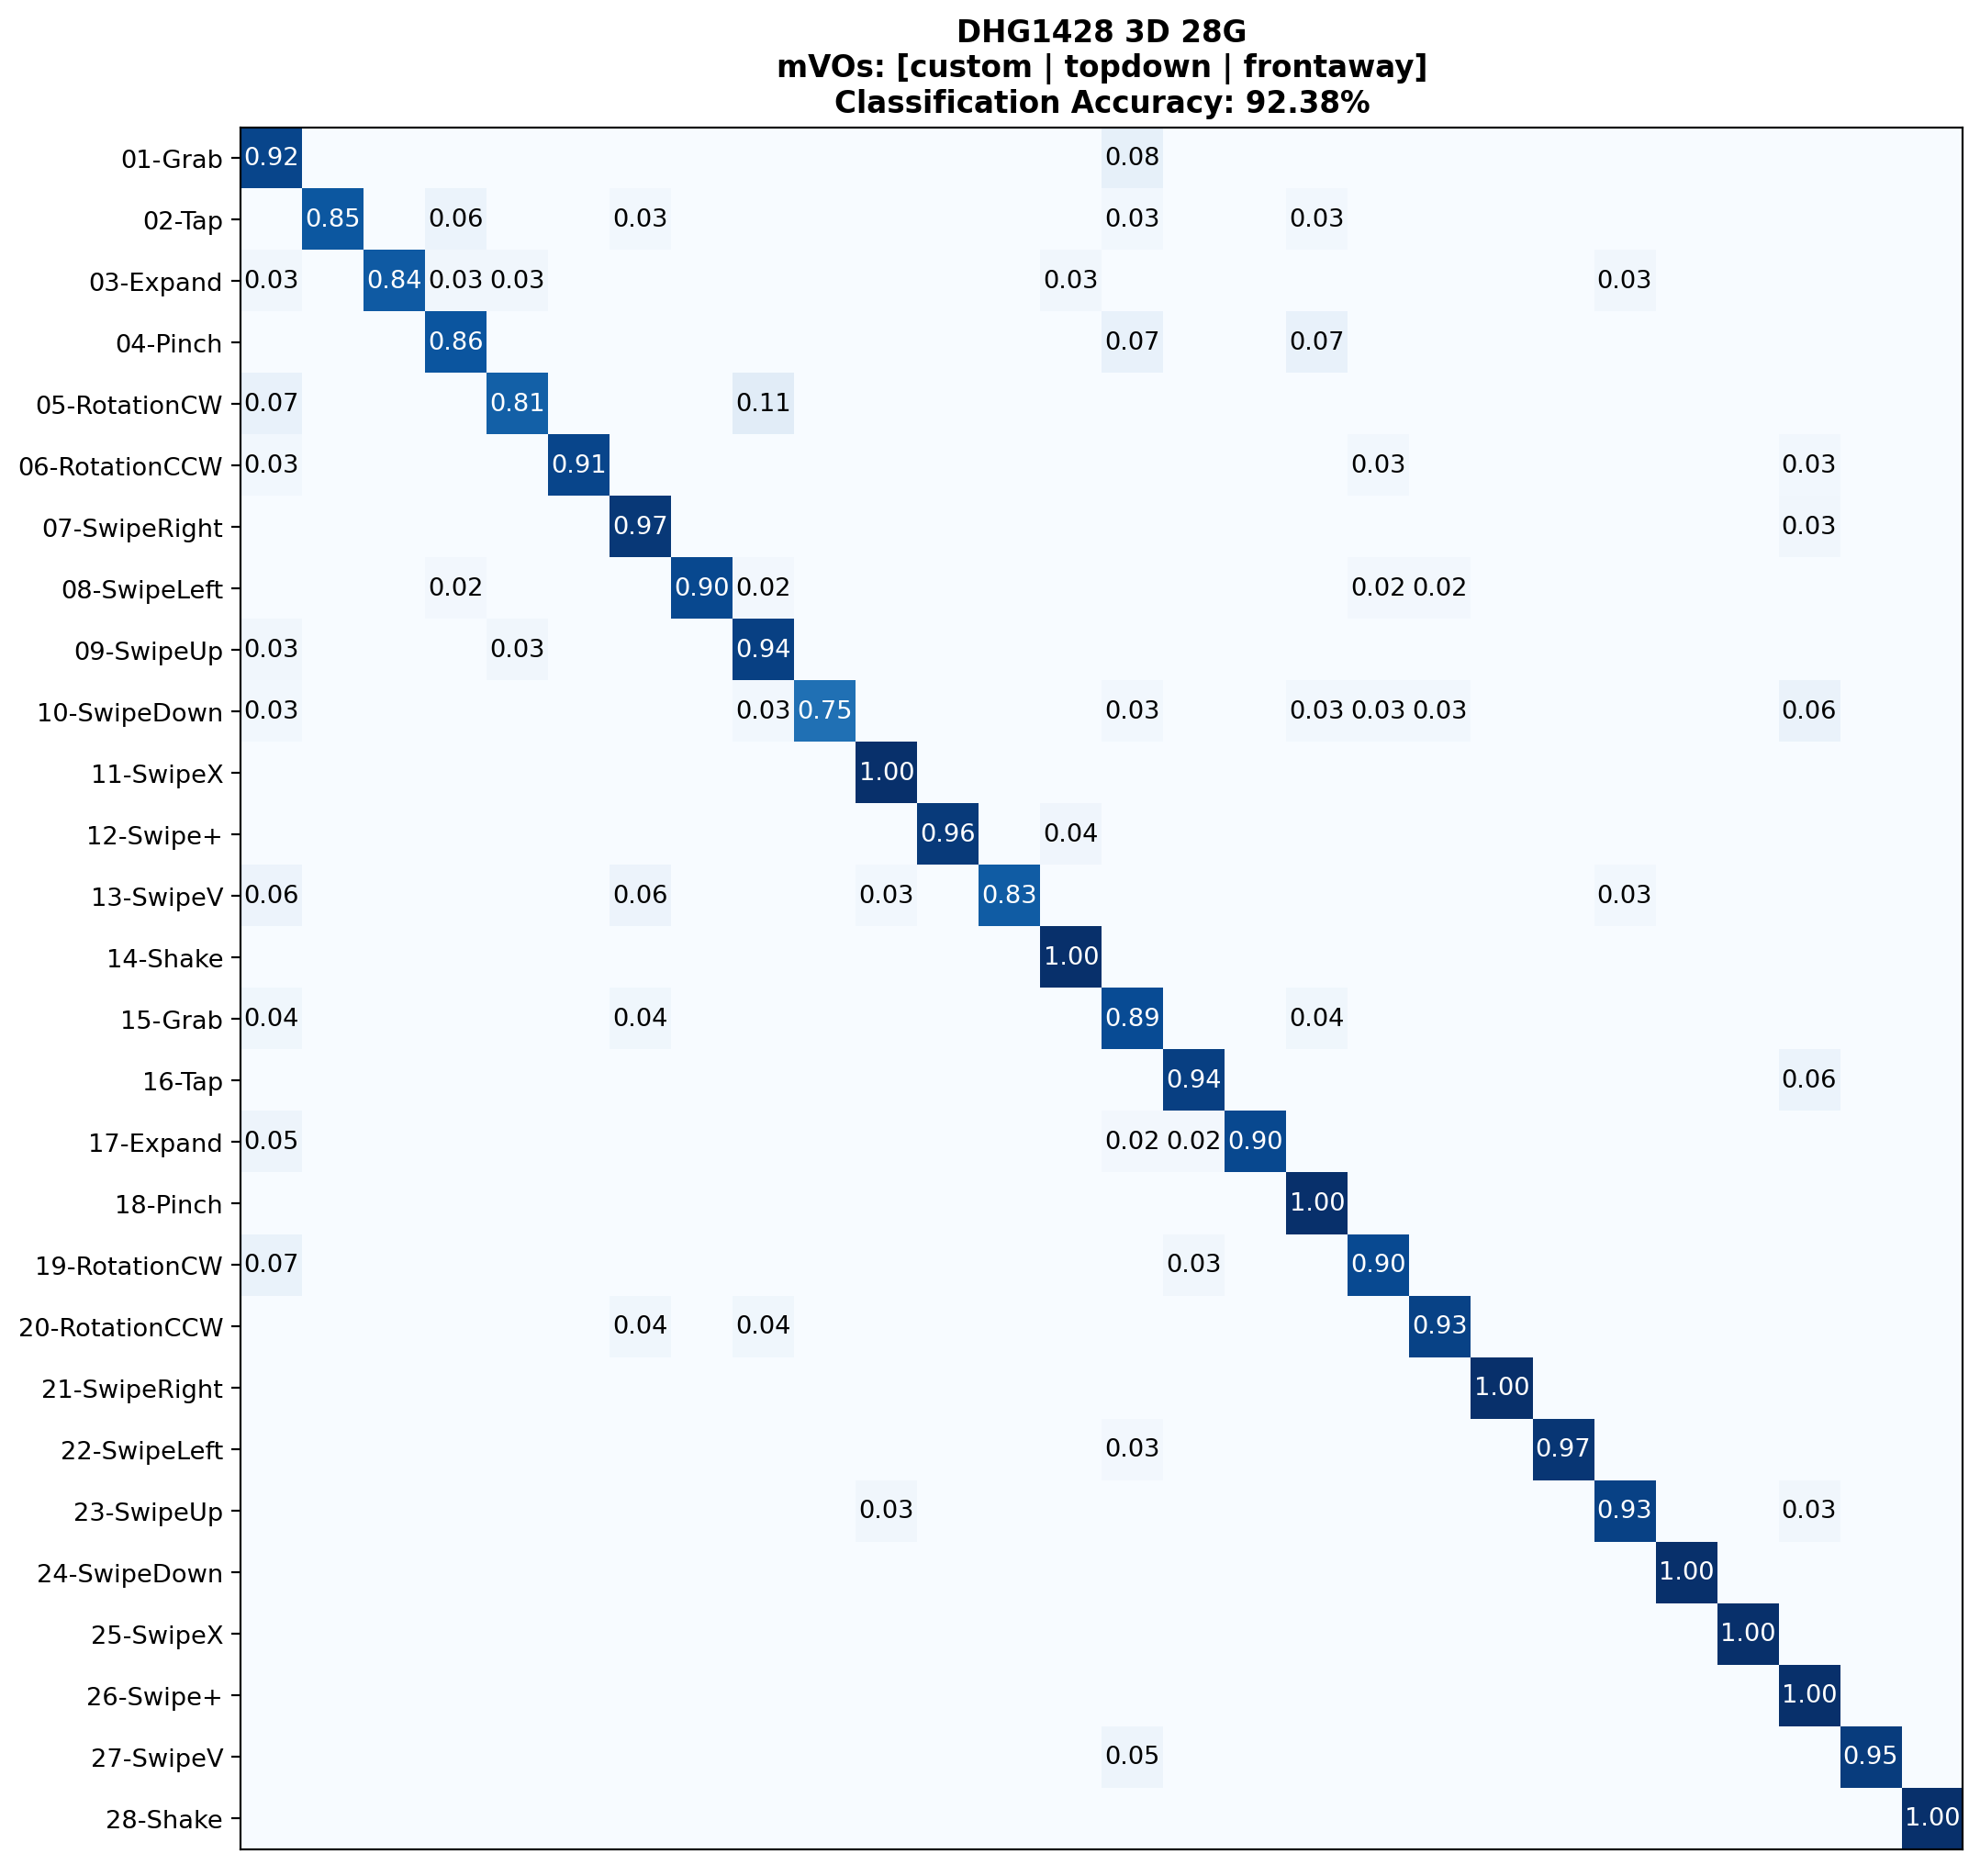

In [76]:
interp = ClassificationInterpretation(dls, dummy_inputs, preds, targs, decoded, dummy_losses)
interp.plot_confusion_matrix(normalize=True, figsize=(11, 11), dpi=196, title=args.cm_title)


In [78]:
print(*interp.most_confused(min_val=1), sep="\n")
# interp.print_classification_report()

('05-RotationCW', '09-SwipeUp', 3)
('01-Grab', '15-Grab', 2)
('02-Tap', '04-Pinch', 2)
('04-Pinch', '15-Grab', 2)
('04-Pinch', '18-Pinch', 2)
('05-RotationCW', '01-Grab', 2)
('10-SwipeDown', '26-Swipe+', 2)
('13-SwipeV', '01-Grab', 2)
('13-SwipeV', '07-SwipeRight', 2)
('16-Tap', '26-Swipe+', 2)
('17-Expand', '01-Grab', 2)
('19-RotationCW', '01-Grab', 2)
('02-Tap', '07-SwipeRight', 1)
('02-Tap', '15-Grab', 1)
('02-Tap', '18-Pinch', 1)
('03-Expand', '01-Grab', 1)
('03-Expand', '04-Pinch', 1)
('03-Expand', '05-RotationCW', 1)
('03-Expand', '14-Shake', 1)
('03-Expand', '23-SwipeUp', 1)
('06-RotationCCW', '01-Grab', 1)
('06-RotationCCW', '19-RotationCW', 1)
('06-RotationCCW', '26-Swipe+', 1)
('07-SwipeRight', '26-Swipe+', 1)
('08-SwipeLeft', '04-Pinch', 1)
('08-SwipeLeft', '09-SwipeUp', 1)
('08-SwipeLeft', '19-RotationCW', 1)
('08-SwipeLeft', '20-RotationCCW', 1)
('09-SwipeUp', '01-Grab', 1)
('09-SwipeUp', '05-RotationCW', 1)
('10-SwipeDown', '01-Grab', 1)
('10-SwipeDown', '09-SwipeUp', 1)


In [100]:
mode_confusion_counter = 0
class_confusion_counter = {}

for (actual, predicted, n_occcurences) in interp.most_confused(min_val=1):
    # mode_confusion_counter
    if (args.ds_name in ["SHREC2017", "DHG1428"]):
        if actual.split("-")[-1] == predicted.split("-")[-1]:
            mode_confusion_counter += n_occcurences
            print("\t", actual, predicted, n_occcurences)

    # class_confusion_counter
    if actual not in class_confusion_counter.keys(): 
        class_confusion_counter[actual] = n_occcurences
    else:
        class_confusion_counter[actual] += n_occcurences
        
print(f"{mode_confusion_counter = }")

class_confusion_counter = sorted(class_confusion_counter.items(), key=lambda i: i[1], reverse=True)
print("class_confusion_counter = ", *class_confusion_counter, sep="\n\t")


	 01-Grab 15-Grab 2
	 04-Pinch 18-Pinch 2
	 15-Grab 01-Grab 1
mode_confusion_counter = 5
class_confusion_counter = 
	('10-SwipeDown', 8)
	('13-SwipeV', 6)
	('05-RotationCW', 5)
	('02-Tap', 5)
	('03-Expand', 5)
	('04-Pinch', 4)
	('17-Expand', 4)
	('08-SwipeLeft', 4)
	('19-RotationCW', 3)
	('06-RotationCCW', 3)
	('15-Grab', 3)
	('01-Grab', 2)
	('16-Tap', 2)
	('09-SwipeUp', 2)
	('20-RotationCCW', 2)
	('23-SwipeUp', 2)
	('07-SwipeRight', 1)
	('12-Swipe+', 1)
	('22-SwipeLeft', 1)
	('27-SwipeV', 1)
